# Alternative solution using pressure values as independent variables
The purpose of MICP experiments is to measure injected mercury volume as a function of pressure, so, in my opinion, pressure values should be independent variables. They may be unknown, in which case it is possible to use the maximum range from 0 to 60,000 psi (maximum pressure in MICP experiments).

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.multioutput import MultiOutputRegressor
import chime
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_percentage_error

Visualization:

In [2]:
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.visualization.matplotlib import plot_param_importances

Audible notification:

In [3]:
%load_ext chime

# Model performance metric 
The target variables, bv and pc (i.e mercury volume and pressure) use different scales: pressure scale is 3 orders of magnitude larger. So the variables and their prediction errors are not comparable. Moreover, pressure and volume themselves vary across wide ranges (also a few order of magnitude wide). Therefore, I use mean average percentage error to evaluage model performance. 

# Data preparation
- Group is a sequential well number that does not have physical sense. It is also uniquely defined by well coordinates. So I drop this column.
- Well coordinates as such also do not determine anything but relative well proximity to each other can result in similarities, so I keep them in.
- Same sample numbers across different wells do not result in any similarity so I drop this column as well.
- The only categorical feature (and a very important one) is lithology, so I will one-hot encode it.
- I will take logarithm of pressure due to a very wide range
- All other values will be standardized as usual.

In [4]:
train = pd.read_csv('train.csv'); train

,group,sample,depth,por,den,ct_1,ct_2,ct_3,ct_4,ct_5,...,pc_91,pc_92,pc_93,pc_94,pc_95,pc_96,pc_97,pc_98,pc_99,pc_100
0,3,52,1660.178974,18.556209,2.740942,1971.579998,2396.714551,2799.219912,1951.977330,2041.857394,...,20517.973164,23072.031367,25918.199746,29130.680234,32741.818105,36776.940391,41337.948828,46440.194570,52182.348633,58608.434023
1,4,92,3890.779426,8.555400,2.834776,2513.180531,3001.782975,2348.160682,2414.636280,2798.706138,...,4178.079326,4564.280930,4987.905991,5457.903966,5976.209199,6537.572468,7149.014724,7826.130471,8559.884813,9368.567796
2,3,90,2287.441253,-0.169935,2.761468,2274.773580,1083.899155,2974.647775,2713.863889,2381.094609,...,20522.705605,23075.290605,25927.208926,29136.474492,32743.575156,36780.525273,41344.256875,46461.810508,52207.803164,58651.855859
3,3,49,2144.788740,28.192998,2.637605,1776.270868,2374.721334,2670.367528,2814.751969,2919.311685,...,20522.544570,23075.227422,25928.721426,29137.418496,32742.759414,36779.554531,41344.410508,46463.711484,52212.429531,58661.142344
4,2,65,3754.453151,4.136069,2.900202,1787.771840,1893.016733,2818.411074,1542.522104,2246.952313,...,4223.781546,4615.144614,5045.280631,5520.831567,6044.115860,6611.085441,7231.857753,7913.697529,8657.308785,9475.725759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,5,51,2097.045676,14.781216,2.688458,2455.839335,2480.124636,2574.049871,2511.215039,2395.579990,...,20522.071465,23074.956074,25926.207676,29135.754883,32743.289434,36780.388477,41343.607969,46459.794961,52204.491289,58646.683398
451,5,35,2078.198020,19.385152,2.684518,2044.566279,2052.309283,2343.335254,2529.277934,2360.570479,...,20515.948887,23070.407505,25916.965068,29127.595225,32738.985176,36777.577871,41334.507256,46434.336172,52175.582588,58596.777002
452,2,68,3672.405920,26.585923,2.772035,2040.649000,2573.163502,1292.780567,2079.696767,2355.948265,...,4384.635758,4792.584608,5241.195855,5734.702477,6275.782170,6869.952183,7510.868407,8221.208958,8994.294442,9843.708743
453,5,6,2094.513127,16.977858,2.705836,2591.491630,2295.452470,2432.286576,2406.785838,2705.931007,...,20522.289775,23073.814199,25925.970928,29138.137822,32746.070488,36781.718086,41348.267930,46455.386035,52207.608379,58647.802676


In [5]:
geology = train.iloc[:, :20]; geology

,group,sample,depth,por,den,ct_1,ct_2,ct_3,ct_4,ct_5,ct_6,ct_7,permeability,ntg,thickness_effective,x,y,lithology,gr,rhob
0,3,52,1660.178974,18.556209,2.740942,1971.579998,2396.714551,2799.219912,1951.977330,2041.857394,2442.840273,2318.618853,6.425410,0.106890,5.658985,18985,5423,limestone,37.738168,2.664759
1,4,92,3890.779426,8.555400,2.834776,2513.180531,3001.782975,2348.160682,2414.636280,2798.706138,3035.549168,2729.578887,14.300516,0.718312,4.483886,16790,3644,shale,42.371106,2.760788
2,3,90,2287.441253,-0.169935,2.761468,2274.773580,1083.899155,2974.647775,2713.863889,2381.094609,2085.069195,2747.971468,12.825353,0.639979,6.349391,18985,5423,sandstone,42.931089,2.624635
3,3,49,2144.788740,28.192998,2.637605,1776.270868,2374.721334,2670.367528,2814.751969,2919.311685,2016.024319,2546.626337,13.320168,0.288901,3.819145,18985,5423,limestone,39.485022,2.634539
4,2,65,3754.453151,4.136069,2.900202,1787.771840,1893.016733,2818.411074,1542.522104,2246.952313,1943.089817,1561.393112,7.183351,0.500868,6.593625,16169,5288,siltstome,34.846060,2.459622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,5,51,2097.045676,14.781216,2.688458,2455.839335,2480.124636,2574.049871,2511.215039,2395.579990,2439.147140,2089.051532,41.015660,0.709441,7.313445,19850,3873,limestone,30.240244,2.562103
451,5,35,2078.198020,19.385152,2.684518,2044.566279,2052.309283,2343.335254,2529.277934,2360.570479,2256.546050,2663.343376,1.366440,0.554834,8.669671,19850,3873,limestone,14.771108,2.617332
452,2,68,3672.405920,26.585923,2.772035,2040.649000,2573.163502,1292.780567,2079.696767,2355.948265,2281.831720,2071.560649,3.371203,0.786869,4.971094,16169,5288,sandstone,41.162699,2.687207
453,5,6,2094.513127,16.977858,2.705836,2591.491630,2295.452470,2432.286576,2406.785838,2705.931007,2400.377198,2512.672454,16.081238,0.671111,7.022591,19850,3873,sandstone,37.093964,2.653836


In [6]:
pressure = train.filter(regex='^pc_'); pressure

,pc_0,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9,...,pc_91,pc_92,pc_93,pc_94,pc_95,pc_96,pc_97,pc_98,pc_99,pc_100
0,0.535189,0.595750,0.665606,0.745420,0.835103,0.932039,1.038247,1.156261,1.292918,1.448585,...,20517.973164,23072.031367,25918.199746,29130.680234,32741.818105,36776.940391,41337.948828,46440.194570,52182.348633,58608.434023
1,0.908788,1.038644,1.168391,1.298765,1.437975,1.558354,1.814425,1.966166,2.169002,2.359788,...,4178.079326,4564.280930,4987.905991,5457.903966,5976.209199,6537.572468,7149.014724,7826.130471,8559.884813,9368.567796
2,0.531813,0.591931,0.661652,0.741723,0.831225,0.928339,1.035978,1.155482,1.291775,1.447311,...,20522.705605,23075.290605,25927.208926,29136.474492,32743.575156,36780.525273,41344.256875,46461.810508,52207.803164,58651.855859
3,0.530184,0.590141,0.659933,0.740125,0.829539,0.926774,1.034327,1.154018,1.290386,1.445932,...,20522.544570,23075.227422,25928.721426,29137.418496,32742.759414,36779.554531,41344.410508,46463.711484,52212.429531,58661.142344
4,0.908399,1.037779,1.167289,1.297142,1.436113,1.557094,1.813521,1.964542,2.168307,2.358832,...,4223.781546,4615.144614,5045.280631,5520.831567,6044.115860,6611.085441,7231.857753,7913.697529,8657.308785,9475.725759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,0.532050,0.592537,0.662303,0.742076,0.831483,0.928488,1.036162,1.155606,1.291590,1.447329,...,20522.071465,23074.956074,25926.207676,29135.754883,32743.289434,36780.388477,41343.607969,46459.794961,52204.491289,58646.683398
451,0.535261,0.596386,0.666660,0.745552,0.834887,0.932013,1.038366,1.156286,1.292117,1.448102,...,20515.948887,23070.407505,25916.965068,29127.595225,32738.985176,36777.577871,41334.507256,46434.336172,52175.582588,58596.777002
452,0.908082,1.037725,1.166750,1.297510,1.436421,1.557271,1.813146,1.964591,2.167796,2.358566,...,4384.635758,4792.584608,5241.195855,5734.702477,6275.782170,6869.952183,7510.868407,8221.208958,8994.294442,9843.708743
453,0.534512,0.593998,0.663882,0.744470,0.834432,0.932015,1.038154,1.156274,1.293843,1.448943,...,20522.289775,23073.814199,25925.970928,29138.137822,32746.070488,36781.718086,41348.267930,46455.386035,52207.608379,58647.802676


In [7]:
X = pd.concat([geology, pressure], axis=1); X

,group,sample,depth,por,den,ct_1,ct_2,ct_3,ct_4,ct_5,...,pc_91,pc_92,pc_93,pc_94,pc_95,pc_96,pc_97,pc_98,pc_99,pc_100
0,3,52,1660.178974,18.556209,2.740942,1971.579998,2396.714551,2799.219912,1951.977330,2041.857394,...,20517.973164,23072.031367,25918.199746,29130.680234,32741.818105,36776.940391,41337.948828,46440.194570,52182.348633,58608.434023
1,4,92,3890.779426,8.555400,2.834776,2513.180531,3001.782975,2348.160682,2414.636280,2798.706138,...,4178.079326,4564.280930,4987.905991,5457.903966,5976.209199,6537.572468,7149.014724,7826.130471,8559.884813,9368.567796
2,3,90,2287.441253,-0.169935,2.761468,2274.773580,1083.899155,2974.647775,2713.863889,2381.094609,...,20522.705605,23075.290605,25927.208926,29136.474492,32743.575156,36780.525273,41344.256875,46461.810508,52207.803164,58651.855859
3,3,49,2144.788740,28.192998,2.637605,1776.270868,2374.721334,2670.367528,2814.751969,2919.311685,...,20522.544570,23075.227422,25928.721426,29137.418496,32742.759414,36779.554531,41344.410508,46463.711484,52212.429531,58661.142344
4,2,65,3754.453151,4.136069,2.900202,1787.771840,1893.016733,2818.411074,1542.522104,2246.952313,...,4223.781546,4615.144614,5045.280631,5520.831567,6044.115860,6611.085441,7231.857753,7913.697529,8657.308785,9475.725759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,5,51,2097.045676,14.781216,2.688458,2455.839335,2480.124636,2574.049871,2511.215039,2395.579990,...,20522.071465,23074.956074,25926.207676,29135.754883,32743.289434,36780.388477,41343.607969,46459.794961,52204.491289,58646.683398
451,5,35,2078.198020,19.385152,2.684518,2044.566279,2052.309283,2343.335254,2529.277934,2360.570479,...,20515.948887,23070.407505,25916.965068,29127.595225,32738.985176,36777.577871,41334.507256,46434.336172,52175.582588,58596.777002
452,2,68,3672.405920,26.585923,2.772035,2040.649000,2573.163502,1292.780567,2079.696767,2355.948265,...,4384.635758,4792.584608,5241.195855,5734.702477,6275.782170,6869.952183,7510.868407,8221.208958,8994.294442,9843.708743
453,5,6,2094.513127,16.977858,2.705836,2591.491630,2295.452470,2432.286576,2406.785838,2705.931007,...,20522.289775,23073.814199,25925.970928,29138.137822,32746.070488,36781.718086,41348.267930,46455.386035,52207.608379,58647.802676


In [8]:
y = train.filter(regex='^bv_'); y

,bv_0,bv_1,bv_2,bv_3,bv_4,bv_5,bv_6,bv_7,bv_8,bv_9,...,bv_91,bv_92,bv_93,bv_94,bv_95,bv_96,bv_97,bv_98,bv_99,bv_100
0,8.314193e-30,0.022937,0.175831,0.343738,0.457215,0.544975,0.619610,0.668326,0.714923,0.758957,...,18.272765,18.298018,18.320578,18.341130,18.359811,18.369696,18.377619,18.377846,18.378063,18.378261
1,8.404712e-30,0.065743,0.110847,0.149221,0.182478,0.207055,0.251148,0.264525,0.286616,0.296471,...,7.703552,7.729920,7.762970,7.786158,7.807564,7.832035,7.853543,7.873677,7.889946,7.903239
2,9.628115e-30,0.065462,0.126050,0.185575,0.236476,0.276897,0.326915,0.352935,0.379736,0.399494,...,3.323700,3.392507,3.455950,3.515671,3.572989,3.626552,3.677021,3.717735,3.751224,3.785149
3,1.001518e-29,0.035238,0.135762,0.260780,0.354239,0.437589,0.512409,0.573600,0.627993,0.674529,...,29.457616,29.462819,29.467363,29.471621,29.475390,29.477765,29.480009,29.482167,29.484013,29.485694
4,1.003009e-29,0.064098,0.117940,0.167830,0.213313,0.245085,0.286452,0.302900,0.324897,0.341102,...,3.721371,3.787876,3.844572,3.896132,3.944263,3.987842,4.027115,4.057976,4.080364,4.101747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,8.405910e-30,0.011935,0.266474,0.392014,0.488393,0.561142,0.629793,0.674519,0.721665,0.761462,...,14.737324,14.754105,14.769177,14.782801,14.794812,14.805402,14.809196,14.809561,14.809862,14.810078
451,9.770500e-30,0.035415,0.148900,0.262791,0.349767,0.428302,0.524900,0.561232,0.611864,0.654517,...,19.464941,19.480960,19.495513,19.507846,19.517875,19.522732,19.525760,19.527513,19.529068,19.530144
452,9.858864e-30,0.035401,0.105316,0.252543,0.343569,0.436199,0.520484,0.579677,0.666790,0.735258,...,27.938931,27.943315,27.947413,27.951092,27.954383,27.956902,27.959231,27.961456,27.963561,27.965526
453,1.020829e-29,0.035444,0.181987,0.246770,0.296267,0.331121,0.381807,0.402956,0.436622,0.463018,...,15.804989,15.818642,15.830467,15.840493,15.845425,15.847699,15.848337,15.848766,15.849141,15.849408


In [9]:
class Preprocess():
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        df = X.copy()
        self.geology_cols = df.iloc[:, :20] \
            .drop(columns=['group', 'sample', 'lithology']) \
            .columns
        self.pressure_cols = df.filter(regex='^pc_').columns
        self.categoric_cols = df.select_dtypes(include='object').columns

        ct = ColumnTransformer(
            [
                ('onehot', OneHotEncoder(handle_unknown='infrequent_if_exist', drop=None),
                     self.categoric_cols),
                ('scale', StandardScaler(), self.geology_cols)
            ],
            n_jobs=-1
        )
        self.transf = ct.fit(df)
        self.features = ct.get_feature_names_out()
        return self
    
    def transform(self, X, y=None):
        df = X.copy().drop(columns=['group', 'sample'])
        geology = pd.DataFrame(self.transf.transform(df), columns=self.features)
        pressure = df[self.pressure_cols].apply(np.log)
        return pd.concat([geology, pressure], axis=1)


In [10]:
prep = Preprocess().fit(X)

In [11]:
X_prep = prep.transform(X)
X_prep

,onehot__lithology_clay sandstone,onehot__lithology_limestone,onehot__lithology_sandstone,onehot__lithology_shale,onehot__lithology_siltstome,scale__depth,scale__por,scale__den,scale__ct_1,scale__ct_2,...,pc_91,pc_92,pc_93,pc_94,pc_95,pc_96,pc_97,pc_98,pc_99,pc_100
0,0.0,1.0,0.0,0.0,0.0,-1.497434,0.249045,-0.111626,-1.219575,0.003803,...,9.929057,10.046376,10.162701,10.279547,10.396408,10.512626,10.629536,10.745921,10.862500,10.978634
1,0.0,0.0,0.0,1.0,0.0,1.580383,-0.766025,1.035027,0.411760,1.682853,...,8.337607,8.426016,8.514771,8.604820,8.695542,8.785321,8.874730,8.965223,9.054842,9.145116
2,0.0,0.0,1.0,0.0,0.0,-0.631928,-1.651635,0.139207,-0.306337,-3.639227,...,9.929287,10.046518,10.163048,10.279746,10.396462,10.512724,10.629689,10.746386,10.862987,10.979374
3,0.0,1.0,0.0,0.0,0.0,-0.828762,1.227167,-1.374409,-1.807858,-0.057228,...,9.929279,10.046515,10.163107,10.279778,10.396437,10.512697,10.629693,10.746427,10.863076,10.979533
4,0.0,0.0,0.0,0.0,1.0,1.392278,-1.214581,1.834544,-1.773216,-1.393946,...,8.348486,8.437098,8.526209,8.616284,8.706840,8.796503,8.886251,8.976350,9.066159,9.156489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,0.0,1.0,0.0,0.0,0.0,-0.894639,-0.134112,-0.752990,0.239044,0.235264,...,9.929256,10.046503,10.163010,10.279721,10.396453,10.512720,10.629673,10.746343,10.862924,10.979286
451,0.0,1.0,0.0,0.0,0.0,-0.920645,0.333181,-0.801132,-0.999735,-0.951913,...,9.928958,10.046306,10.162653,10.279441,10.396322,10.512644,10.629453,10.745794,10.862370,10.978435
452,0.0,0.0,1.0,0.0,0.0,1.279068,1.064050,0.268330,-1.011535,0.493444,...,8.385862,8.474825,8.564305,8.654291,8.744453,8.834912,8.924106,9.014473,9.104346,9.194588
453,0.0,0.0,1.0,0.0,0.0,-0.898133,0.088844,-0.540626,0.647638,-0.277197,...,9.929267,10.046454,10.163000,10.279803,10.396538,10.512756,10.629786,10.746248,10.862984,10.979305


In [12]:
X_train, X_val, y_train, y_val = train_test_split(X_prep, y,
                                                  test_size=45,
                                                  random_state=8,
                                                  shuffle=True)


# Baseline model. Ordinary least squares linear regression

In [19]:
from sklearn.linear_model import LinearRegression

In [20]:
lr = LinearRegression(n_jobs=-1).fit(X_train, y_train)

In [21]:
y_pred = lr.predict(X_val)

In [22]:
mean_absolute_percentage_error(y_val, y_pred)

0.5754477487658375

Example curve

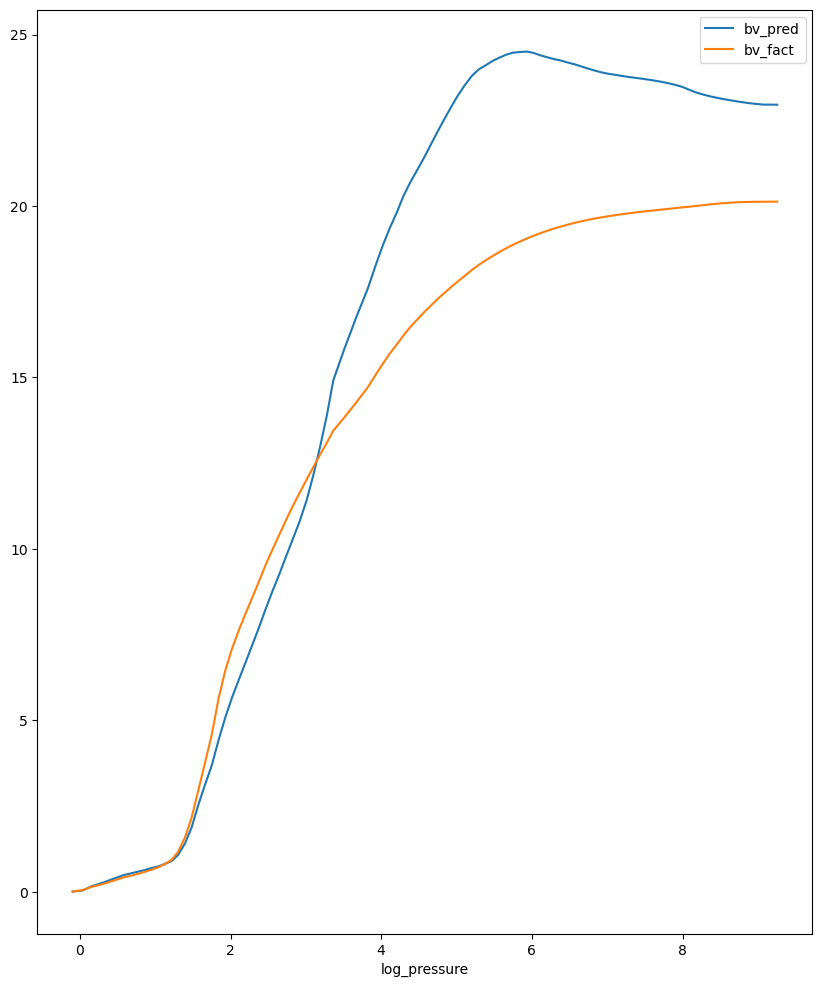

In [25]:
pd.DataFrame({'log_pressure': X_val.filter(regex='pc_').iloc[0, :].to_list(),
              'bv_pred':y_pred[0, :].tolist(),
              'bv_fact': y_val.iloc[0, :].to_list()}) \
    .plot.line(x='log_pressure', y=['bv_pred', 'bv_fact'], figsize=(10,12));

Feature importance:

In [29]:
feature_importance = pd.DataFrame(lr.coef_, columns = X_prep.columns).mean(axis=0).abs().sort_values(ascending=False)
feature_importance.head(20)

pc_35    9.920031e+06
pc_34    5.565515e+06
pc_33    4.061165e+06
pc_26    3.115999e+06
pc_32    2.022171e+06
pc_31    1.883059e+06
pc_88    1.728465e+06
pc_19    1.606785e+06
pc_29    1.570292e+06
pc_87    1.321934e+06
pc_92    1.319392e+06
pc_96    1.271971e+06
pc_99    1.154558e+06
pc_93    1.097378e+06
pc_24    1.036412e+06
pc_91    9.843024e+05
pc_95    9.446993e+05
pc_27    9.338211e+05
pc_28    8.475343e+05
pc_94    7.772646e+05
dtype: float64

# Model optimization

## Linear regression with regularization

In [30]:
from sklearn.linear_model import Ridge

In [31]:
estimator = Ridge(random_state=8)

In [37]:
params = {
    'alpha': [1e-6, 1e-5, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 20],
}

In [38]:
model = GridSearchCV(
    estimator=estimator,
    param_grid=params,
    scoring='neg_mean_absolute_percentage_error',
    n_jobs=-1,
    cv=10,
    verbose=3)

In [39]:
%%time
%%chime
model.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
CPU times: user 96.8 ms, sys: 8.27 ms, total: 105 ms
Wall time: 363 ms


In [40]:
model.best_params_

{'alpha': 10}

In [41]:
model.best_score_

-0.526113026880459

In [42]:
y_pred = model.predict(X_val)

In [43]:
mean_absolute_percentage_error(y_val, y_pred)

0.4843865655647991

Some improvement compared to ordinary linear regression.

Example curve

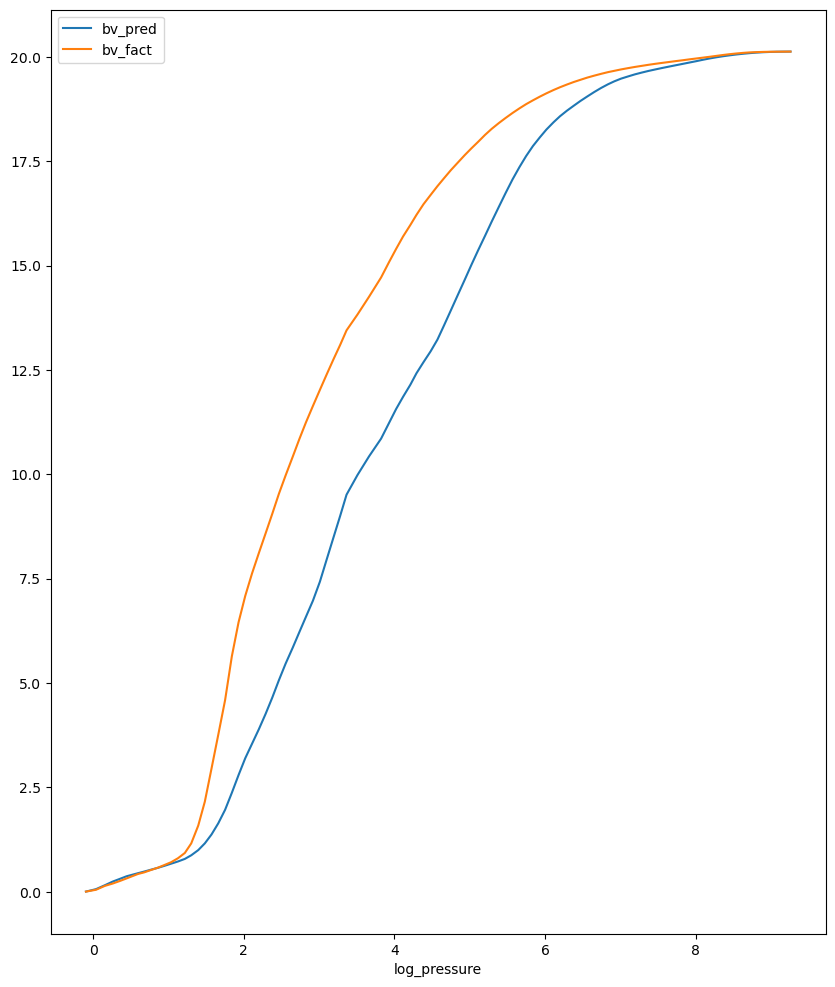

In [44]:
pd.DataFrame({'log_pressure': X_val.filter(regex='pc_').iloc[0, :].to_list(),
              'bv_pred':y_pred[0, :].tolist(),
              'bv_fact': y_val.iloc[0, :].to_list()}) \
    .plot.line(x='log_pressure', y=['bv_pred', 'bv_fact'], figsize=(10,12));

# KNN

In [45]:
from sklearn.neighbors import KNeighborsRegressor

In [46]:
estimator = KNeighborsRegressor(metric='minkowski', n_jobs=-1)

In [47]:
params = {
    'n_neighbors': list(range(2,25)),
    'weights': ['uniform', 'distance'],
    'p': [1, 2, 3]
}

In [48]:
model = GridSearchCV(
    estimator=estimator,
    param_grid=params,
    scoring='neg_mean_absolute_percentage_error',
    cv=10,
    verbose=3)

In [49]:
%%time
%%chime
model.fit(X_train, y_train)

Fitting 10 folds for each of 138 candidates, totalling 1380 fits
[CV 1/10] END n_neighbors=2, p=1, weights=uniform;, score=-0.600 total time=   0.0s
[CV 2/10] END n_neighbors=2, p=1, weights=uniform;, score=-0.808 total time=   0.0s
[CV 3/10] END n_neighbors=2, p=1, weights=uniform;, score=-0.662 total time=   0.0s
[CV 4/10] END n_neighbors=2, p=1, weights=uniform;, score=-0.560 total time=   0.0s
[CV 5/10] END n_neighbors=2, p=1, weights=uniform;, score=-0.421 total time=   0.0s
[CV 6/10] END n_neighbors=2, p=1, weights=uniform;, score=-0.961 total time=   0.0s
[CV 7/10] END n_neighbors=2, p=1, weights=uniform;, score=-0.456 total time=   0.0s
[CV 8/10] END n_neighbors=2, p=1, weights=uniform;, score=-0.966 total time=   0.0s
[CV 9/10] END n_neighbors=2, p=1, weights=uniform;, score=-0.424 total time=   0.0s
[CV 10/10] END n_neighbors=2, p=1, weights=uniform;, score=-0.817 total time=   0.0s
[CV 1/10] END n_neighbors=2, p=1, weights=distance;, score=-0.604 total time=   0.0s
[CV 2/10]

[CV 3/10] END n_neighbors=3, p=3, weights=uniform;, score=-0.664 total time=   0.1s
[CV 4/10] END n_neighbors=3, p=3, weights=uniform;, score=-0.598 total time=   0.1s
[CV 5/10] END n_neighbors=3, p=3, weights=uniform;, score=-0.406 total time=   0.1s
[CV 6/10] END n_neighbors=3, p=3, weights=uniform;, score=-0.944 total time=   0.1s
[CV 7/10] END n_neighbors=3, p=3, weights=uniform;, score=-0.456 total time=   0.1s
[CV 8/10] END n_neighbors=3, p=3, weights=uniform;, score=-0.878 total time=   0.1s
[CV 9/10] END n_neighbors=3, p=3, weights=uniform;, score=-0.489 total time=   0.1s
[CV 10/10] END n_neighbors=3, p=3, weights=uniform;, score=-0.573 total time=   0.1s
[CV 1/10] END n_neighbors=3, p=3, weights=distance;, score=-0.638 total time=   0.1s
[CV 2/10] END n_neighbors=3, p=3, weights=distance;, score=-0.727 total time=   0.1s
[CV 3/10] END n_neighbors=3, p=3, weights=distance;, score=-0.659 total time=   0.1s
[CV 4/10] END n_neighbors=3, p=3, weights=distance;, score=-0.595 total 

[CV 4/10] END n_neighbors=5, p=2, weights=uniform;, score=-0.592 total time=   0.0s
[CV 5/10] END n_neighbors=5, p=2, weights=uniform;, score=-0.408 total time=   0.0s
[CV 6/10] END n_neighbors=5, p=2, weights=uniform;, score=-0.931 total time=   0.0s
[CV 7/10] END n_neighbors=5, p=2, weights=uniform;, score=-0.422 total time=   0.0s
[CV 8/10] END n_neighbors=5, p=2, weights=uniform;, score=-0.881 total time=   0.0s
[CV 9/10] END n_neighbors=5, p=2, weights=uniform;, score=-0.497 total time=   0.0s
[CV 10/10] END n_neighbors=5, p=2, weights=uniform;, score=-0.604 total time=   0.0s
[CV 1/10] END n_neighbors=5, p=2, weights=distance;, score=-0.616 total time=   0.0s
[CV 2/10] END n_neighbors=5, p=2, weights=distance;, score=-0.816 total time=   0.0s
[CV 3/10] END n_neighbors=5, p=2, weights=distance;, score=-0.674 total time=   0.0s
[CV 4/10] END n_neighbors=5, p=2, weights=distance;, score=-0.587 total time=   0.0s
[CV 5/10] END n_neighbors=5, p=2, weights=distance;, score=-0.403 total

[CV 7/10] END n_neighbors=7, p=1, weights=distance;, score=-0.436 total time=   0.0s
[CV 8/10] END n_neighbors=7, p=1, weights=distance;, score=-0.865 total time=   0.0s
[CV 9/10] END n_neighbors=7, p=1, weights=distance;, score=-0.498 total time=   0.0s
[CV 10/10] END n_neighbors=7, p=1, weights=distance;, score=-0.716 total time=   0.0s
[CV 1/10] END n_neighbors=7, p=2, weights=uniform;, score=-0.603 total time=   0.0s
[CV 2/10] END n_neighbors=7, p=2, weights=uniform;, score=-0.811 total time=   0.0s
[CV 3/10] END n_neighbors=7, p=2, weights=uniform;, score=-0.676 total time=   0.0s
[CV 4/10] END n_neighbors=7, p=2, weights=uniform;, score=-0.614 total time=   0.0s
[CV 5/10] END n_neighbors=7, p=2, weights=uniform;, score=-0.373 total time=   0.0s
[CV 6/10] END n_neighbors=7, p=2, weights=uniform;, score=-0.953 total time=   0.0s
[CV 7/10] END n_neighbors=7, p=2, weights=uniform;, score=-0.404 total time=   0.0s
[CV 8/10] END n_neighbors=7, p=2, weights=uniform;, score=-0.939 total 

[CV 6/10] END n_neighbors=8, p=3, weights=distance;, score=-0.971 total time=   0.1s
[CV 7/10] END n_neighbors=8, p=3, weights=distance;, score=-0.427 total time=   0.1s
[CV 8/10] END n_neighbors=8, p=3, weights=distance;, score=-0.928 total time=   0.1s
[CV 9/10] END n_neighbors=8, p=3, weights=distance;, score=-0.556 total time=   0.1s
[CV 10/10] END n_neighbors=8, p=3, weights=distance;, score=-0.645 total time=   0.1s
[CV 1/10] END n_neighbors=9, p=1, weights=uniform;, score=-0.629 total time=   0.0s
[CV 2/10] END n_neighbors=9, p=1, weights=uniform;, score=-0.788 total time=   0.0s
[CV 3/10] END n_neighbors=9, p=1, weights=uniform;, score=-0.664 total time=   0.0s
[CV 4/10] END n_neighbors=9, p=1, weights=uniform;, score=-0.628 total time=   0.0s
[CV 5/10] END n_neighbors=9, p=1, weights=uniform;, score=-0.399 total time=   0.0s
[CV 6/10] END n_neighbors=9, p=1, weights=uniform;, score=-0.872 total time=   0.0s
[CV 7/10] END n_neighbors=9, p=1, weights=uniform;, score=-0.434 total

[CV 7/10] END n_neighbors=10, p=2, weights=distance;, score=-0.412 total time=   0.0s
[CV 8/10] END n_neighbors=10, p=2, weights=distance;, score=-0.983 total time=   0.0s
[CV 9/10] END n_neighbors=10, p=2, weights=distance;, score=-0.549 total time=   0.0s
[CV 10/10] END n_neighbors=10, p=2, weights=distance;, score=-0.660 total time=   0.0s
[CV 1/10] END n_neighbors=10, p=3, weights=uniform;, score=-0.683 total time=   0.1s
[CV 2/10] END n_neighbors=10, p=3, weights=uniform;, score=-0.813 total time=   0.1s
[CV 3/10] END n_neighbors=10, p=3, weights=uniform;, score=-0.746 total time=   0.1s
[CV 4/10] END n_neighbors=10, p=3, weights=uniform;, score=-0.663 total time=   0.1s
[CV 5/10] END n_neighbors=10, p=3, weights=uniform;, score=-0.411 total time=   0.1s
[CV 6/10] END n_neighbors=10, p=3, weights=uniform;, score=-1.009 total time=   0.1s
[CV 7/10] END n_neighbors=10, p=3, weights=uniform;, score=-0.452 total time=   0.1s
[CV 8/10] END n_neighbors=10, p=3, weights=uniform;, score=-

[CV 3/10] END n_neighbors=12, p=2, weights=uniform;, score=-0.728 total time=   0.0s
[CV 4/10] END n_neighbors=12, p=2, weights=uniform;, score=-0.608 total time=   0.0s
[CV 5/10] END n_neighbors=12, p=2, weights=uniform;, score=-0.430 total time=   0.0s
[CV 6/10] END n_neighbors=12, p=2, weights=uniform;, score=-0.961 total time=   0.0s
[CV 7/10] END n_neighbors=12, p=2, weights=uniform;, score=-0.433 total time=   0.0s
[CV 8/10] END n_neighbors=12, p=2, weights=uniform;, score=-0.991 total time=   0.0s
[CV 9/10] END n_neighbors=12, p=2, weights=uniform;, score=-0.565 total time=   0.0s
[CV 10/10] END n_neighbors=12, p=2, weights=uniform;, score=-0.732 total time=   0.0s
[CV 1/10] END n_neighbors=12, p=2, weights=distance;, score=-0.687 total time=   0.0s
[CV 2/10] END n_neighbors=12, p=2, weights=distance;, score=-0.783 total time=   0.0s
[CV 3/10] END n_neighbors=12, p=2, weights=distance;, score=-0.719 total time=   0.0s
[CV 4/10] END n_neighbors=12, p=2, weights=distance;, score=-

[CV 10/10] END n_neighbors=13, p=3, weights=distance;, score=-0.712 total time=   0.1s
[CV 1/10] END n_neighbors=14, p=1, weights=uniform;, score=-0.617 total time=   0.0s
[CV 2/10] END n_neighbors=14, p=1, weights=uniform;, score=-0.766 total time=   0.0s
[CV 3/10] END n_neighbors=14, p=1, weights=uniform;, score=-0.704 total time=   0.0s
[CV 4/10] END n_neighbors=14, p=1, weights=uniform;, score=-0.667 total time=   0.0s
[CV 5/10] END n_neighbors=14, p=1, weights=uniform;, score=-0.438 total time=   0.0s
[CV 6/10] END n_neighbors=14, p=1, weights=uniform;, score=-0.896 total time=   0.0s
[CV 7/10] END n_neighbors=14, p=1, weights=uniform;, score=-0.440 total time=   0.0s
[CV 8/10] END n_neighbors=14, p=1, weights=uniform;, score=-0.922 total time=   0.0s
[CV 9/10] END n_neighbors=14, p=1, weights=uniform;, score=-0.557 total time=   0.0s
[CV 10/10] END n_neighbors=14, p=1, weights=uniform;, score=-0.748 total time=   0.0s
[CV 1/10] END n_neighbors=14, p=1, weights=distance;, score=-0

[CV 2/10] END n_neighbors=15, p=3, weights=uniform;, score=-0.816 total time=   0.1s
[CV 3/10] END n_neighbors=15, p=3, weights=uniform;, score=-0.792 total time=   0.1s
[CV 4/10] END n_neighbors=15, p=3, weights=uniform;, score=-0.666 total time=   0.1s
[CV 5/10] END n_neighbors=15, p=3, weights=uniform;, score=-0.413 total time=   0.1s
[CV 6/10] END n_neighbors=15, p=3, weights=uniform;, score=-1.014 total time=   0.1s
[CV 7/10] END n_neighbors=15, p=3, weights=uniform;, score=-0.469 total time=   0.1s
[CV 8/10] END n_neighbors=15, p=3, weights=uniform;, score=-1.116 total time=   0.1s
[CV 9/10] END n_neighbors=15, p=3, weights=uniform;, score=-0.605 total time=   0.1s
[CV 10/10] END n_neighbors=15, p=3, weights=uniform;, score=-0.716 total time=   0.1s
[CV 1/10] END n_neighbors=15, p=3, weights=distance;, score=-0.703 total time=   0.1s
[CV 2/10] END n_neighbors=15, p=3, weights=distance;, score=-0.811 total time=   0.1s
[CV 3/10] END n_neighbors=15, p=3, weights=distance;, score=-0

[CV 10/10] END n_neighbors=17, p=1, weights=distance;, score=-0.780 total time=   0.0s
[CV 1/10] END n_neighbors=17, p=2, weights=uniform;, score=-0.665 total time=   0.0s
[CV 2/10] END n_neighbors=17, p=2, weights=uniform;, score=-0.800 total time=   0.0s
[CV 3/10] END n_neighbors=17, p=2, weights=uniform;, score=-0.809 total time=   0.0s
[CV 4/10] END n_neighbors=17, p=2, weights=uniform;, score=-0.668 total time=   0.0s
[CV 5/10] END n_neighbors=17, p=2, weights=uniform;, score=-0.438 total time=   0.0s
[CV 6/10] END n_neighbors=17, p=2, weights=uniform;, score=-0.959 total time=   0.0s
[CV 7/10] END n_neighbors=17, p=2, weights=uniform;, score=-0.469 total time=   0.0s
[CV 8/10] END n_neighbors=17, p=2, weights=uniform;, score=-1.061 total time=   0.0s
[CV 9/10] END n_neighbors=17, p=2, weights=uniform;, score=-0.596 total time=   0.0s
[CV 10/10] END n_neighbors=17, p=2, weights=uniform;, score=-0.736 total time=   0.0s
[CV 1/10] END n_neighbors=17, p=2, weights=distance;, score=-0

[CV 9/10] END n_neighbors=18, p=3, weights=distance;, score=-0.612 total time=   0.1s
[CV 10/10] END n_neighbors=18, p=3, weights=distance;, score=-0.739 total time=   0.1s
[CV 1/10] END n_neighbors=19, p=1, weights=uniform;, score=-0.641 total time=   0.0s
[CV 2/10] END n_neighbors=19, p=1, weights=uniform;, score=-0.766 total time=   0.0s
[CV 3/10] END n_neighbors=19, p=1, weights=uniform;, score=-0.719 total time=   0.0s
[CV 4/10] END n_neighbors=19, p=1, weights=uniform;, score=-0.695 total time=   0.0s
[CV 5/10] END n_neighbors=19, p=1, weights=uniform;, score=-0.441 total time=   0.0s
[CV 6/10] END n_neighbors=19, p=1, weights=uniform;, score=-0.885 total time=   0.0s
[CV 7/10] END n_neighbors=19, p=1, weights=uniform;, score=-0.439 total time=   0.0s
[CV 8/10] END n_neighbors=19, p=1, weights=uniform;, score=-0.950 total time=   0.0s
[CV 9/10] END n_neighbors=19, p=1, weights=uniform;, score=-0.588 total time=   0.0s
[CV 10/10] END n_neighbors=19, p=1, weights=uniform;, score=-0

[CV 1/10] END n_neighbors=20, p=3, weights=uniform;, score=-0.702 total time=   0.1s
[CV 2/10] END n_neighbors=20, p=3, weights=uniform;, score=-0.865 total time=   0.1s
[CV 3/10] END n_neighbors=20, p=3, weights=uniform;, score=-0.852 total time=   0.1s
[CV 4/10] END n_neighbors=20, p=3, weights=uniform;, score=-0.684 total time=   0.1s
[CV 5/10] END n_neighbors=20, p=3, weights=uniform;, score=-0.425 total time=   0.1s
[CV 6/10] END n_neighbors=20, p=3, weights=uniform;, score=-1.006 total time=   0.1s
[CV 7/10] END n_neighbors=20, p=3, weights=uniform;, score=-0.483 total time=   0.1s
[CV 8/10] END n_neighbors=20, p=3, weights=uniform;, score=-1.169 total time=   0.1s
[CV 9/10] END n_neighbors=20, p=3, weights=uniform;, score=-0.635 total time=   0.1s
[CV 10/10] END n_neighbors=20, p=3, weights=uniform;, score=-0.743 total time=   0.1s
[CV 1/10] END n_neighbors=20, p=3, weights=distance;, score=-0.697 total time=   0.1s
[CV 2/10] END n_neighbors=20, p=3, weights=distance;, score=-0.

[CV 7/10] END n_neighbors=22, p=1, weights=distance;, score=-0.425 total time=   0.0s
[CV 8/10] END n_neighbors=22, p=1, weights=distance;, score=-0.972 total time=   0.0s
[CV 9/10] END n_neighbors=22, p=1, weights=distance;, score=-0.591 total time=   0.0s
[CV 10/10] END n_neighbors=22, p=1, weights=distance;, score=-0.793 total time=   0.0s
[CV 1/10] END n_neighbors=22, p=2, weights=uniform;, score=-0.687 total time=   0.0s
[CV 2/10] END n_neighbors=22, p=2, weights=uniform;, score=-0.835 total time=   0.0s
[CV 3/10] END n_neighbors=22, p=2, weights=uniform;, score=-0.838 total time=   0.0s
[CV 4/10] END n_neighbors=22, p=2, weights=uniform;, score=-0.707 total time=   0.0s
[CV 5/10] END n_neighbors=22, p=2, weights=uniform;, score=-0.418 total time=   0.0s
[CV 6/10] END n_neighbors=22, p=2, weights=uniform;, score=-0.952 total time=   0.0s
[CV 7/10] END n_neighbors=22, p=2, weights=uniform;, score=-0.471 total time=   0.0s
[CV 8/10] END n_neighbors=22, p=2, weights=uniform;, score=-

[CV 4/10] END n_neighbors=23, p=3, weights=distance;, score=-0.696 total time=   0.1s
[CV 5/10] END n_neighbors=23, p=3, weights=distance;, score=-0.432 total time=   0.1s
[CV 6/10] END n_neighbors=23, p=3, weights=distance;, score=-0.998 total time=   0.1s
[CV 7/10] END n_neighbors=23, p=3, weights=distance;, score=-0.493 total time=   0.1s
[CV 8/10] END n_neighbors=23, p=3, weights=distance;, score=-1.207 total time=   0.1s
[CV 9/10] END n_neighbors=23, p=3, weights=distance;, score=-0.666 total time=   0.1s
[CV 10/10] END n_neighbors=23, p=3, weights=distance;, score=-0.751 total time=   0.1s
[CV 1/10] END n_neighbors=24, p=1, weights=uniform;, score=-0.645 total time=   0.0s
[CV 2/10] END n_neighbors=24, p=1, weights=uniform;, score=-0.812 total time=   0.0s
[CV 3/10] END n_neighbors=24, p=1, weights=uniform;, score=-0.734 total time=   0.0s
[CV 4/10] END n_neighbors=24, p=1, weights=uniform;, score=-0.695 total time=   0.0s
[CV 5/10] END n_neighbors=24, p=1, weights=uniform;, scor

In [50]:
model.best_params_

{'n_neighbors': 4, 'p': 1, 'weights': 'distance'}

In [51]:
model.best_score_

-0.6224380152274456

In [52]:
y_pred = model.predict(X_val)

In [53]:
mean_absolute_percentage_error(y_val, y_pred)

0.44704195562371907

Minor improvement over linear regression on the test set, though cross-validation results are much worse.

# Random forest
Using Optuna to select the best hyperparameters

In [15]:
from sklearn.ensemble import RandomForestRegressor

In [24]:
def objective(trial):
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    if bootstrap:
        max_samples = trial.suggest_float('max_samples', 0.3, 1.0, log=False)
    else:
        max_samples = None
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000, log=True),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'max_depth': trial.suggest_int('max_depth', 2, 100, log=True),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20)
    }

    regressor = RandomForestRegressor(random_state=8, 
                                          bootstrap=bootstrap,
                                          max_samples=max_samples,
                                          **params)
    cv_scores = cross_val_score(regressor, 
                                X_train, y_train, 
                                scoring='neg_mean_absolute_percentage_error', 
                                cv=10)
    return cv_scores.mean()

In [25]:
study = optuna.create_study(
    pruner=optuna.pruners.HyperbandPruner(),
    direction='maximize'
)

[I 2023-03-07 11:02:19,395] A new study created in memory with name: no-name-94f02845-c189-4dab-80c7-970c6bc65f9e


In [26]:
%%time
%%chime
study.optimize(objective, n_trials=100)

[I 2023-03-07 11:02:39,046] Trial 0 finished with value: -0.5876777164229214 and parameters: {'bootstrap': False, 'n_estimators': 246, 'max_features': 'sqrt', 'max_depth': 9, 'min_samples_split': 18}. Best is trial 0 with value: -0.5876777164229214.
[I 2023-03-07 11:03:03,774] Trial 1 finished with value: -0.5705400642812224 and parameters: {'bootstrap': False, 'n_estimators': 265, 'max_features': 'sqrt', 'max_depth': 21, 'min_samples_split': 9}. Best is trial 1 with value: -0.5705400642812224.
[I 2023-03-07 11:03:06,917] Trial 2 finished with value: -0.7259445720188499 and parameters: {'bootstrap': True, 'max_samples': 0.6586428661400694, 'n_estimators': 114, 'max_features': 'sqrt', 'max_depth': 3, 'min_samples_split': 2}. Best is trial 1 with value: -0.5705400642812224.
[I 2023-03-07 11:03:10,638] Trial 3 finished with value: -0.6726902586226899 and parameters: {'bootstrap': False, 'n_estimators': 82, 'max_features': 'log2', 'max_depth': 6, 'min_samples_split': 3}. Best is trial 1 wi

[I 2023-03-07 11:40:43,409] Trial 29 finished with value: -0.3484061786000631 and parameters: {'bootstrap': False, 'n_estimators': 176, 'max_features': None, 'max_depth': 66, 'min_samples_split': 4}. Best is trial 24 with value: -0.328213432913118.
[I 2023-03-07 11:40:47,414] Trial 30 finished with value: -0.6650205986069666 and parameters: {'bootstrap': True, 'max_samples': 0.8296207362466665, 'n_estimators': 92, 'max_features': 'log2', 'max_depth': 64, 'min_samples_split': 5}. Best is trial 24 with value: -0.328213432913118.
[I 2023-03-07 11:41:49,606] Trial 31 finished with value: -0.331150547014117 and parameters: {'bootstrap': True, 'max_samples': 0.9125527764212737, 'n_estimators': 160, 'max_features': None, 'max_depth': 41, 'min_samples_split': 7}. Best is trial 24 with value: -0.328213432913118.
[I 2023-03-07 11:43:08,683] Trial 32 finished with value: -0.33060153678613874 and parameters: {'bootstrap': True, 'max_samples': 0.9219704342284601, 'n_estimators': 201, 'max_features'

[I 2023-03-07 12:42:49,225] Trial 58 finished with value: -0.3274078838030285 and parameters: {'bootstrap': True, 'max_samples': 0.9950673883059369, 'n_estimators': 606, 'max_features': None, 'max_depth': 40, 'min_samples_split': 3}. Best is trial 43 with value: -0.3265529878313387.
[I 2023-03-07 12:45:41,351] Trial 59 finished with value: -0.3421931365845122 and parameters: {'bootstrap': True, 'max_samples': 0.9590075351185137, 'n_estimators': 553, 'max_features': None, 'max_depth': 42, 'min_samples_split': 17}. Best is trial 43 with value: -0.3265529878313387.
[I 2023-03-07 12:48:51,611] Trial 60 finished with value: -0.3279996956316401 and parameters: {'bootstrap': True, 'max_samples': 0.8855145869851797, 'n_estimators': 449, 'max_features': None, 'max_depth': 29, 'min_samples_split': 4}. Best is trial 43 with value: -0.3265529878313387.
[I 2023-03-07 12:52:04,520] Trial 61 finished with value: -0.32796213094119864 and parameters: {'bootstrap': True, 'max_samples': 0.895818014675243

[I 2023-03-07 15:01:10,787] Trial 86 finished with value: -0.3509757505614734 and parameters: {'bootstrap': False, 'n_estimators': 854, 'max_features': None, 'max_depth': 90, 'min_samples_split': 5}. Best is trial 74 with value: -0.32634522526992826.
[I 2023-03-07 15:08:17,443] Trial 87 finished with value: -0.3269574157718286 and parameters: {'bootstrap': True, 'max_samples': 0.9998457151509972, 'n_estimators': 883, 'max_features': None, 'max_depth': 87, 'min_samples_split': 3}. Best is trial 74 with value: -0.32634522526992826.
[I 2023-03-07 15:13:46,079] Trial 88 finished with value: -0.32826425710108964 and parameters: {'bootstrap': True, 'max_samples': 0.998683782906586, 'n_estimators': 709, 'max_features': None, 'max_depth': 82, 'min_samples_split': 4}. Best is trial 74 with value: -0.32634522526992826.
[I 2023-03-07 15:21:27,440] Trial 89 finished with value: -0.3272068051057532 and parameters: {'bootstrap': True, 'max_samples': 0.9810994889112197, 'n_estimators': 965, 'max_feat

CPU times: user 5h 18min 27s, sys: 10.1 s, total: 5h 18min 37s
Wall time: 5h 19min 10s


In [27]:
study.best_params

{'bootstrap': True,
 'max_samples': 0.9366972545422723,
 'n_estimators': 705,
 'max_features': None,
 'max_depth': 80,
 'min_samples_split': 2}

In [28]:
study.best_value

-0.32634522526992826

/tmp/ipykernel_11131/3324289224.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study)


<AxesSubplot: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

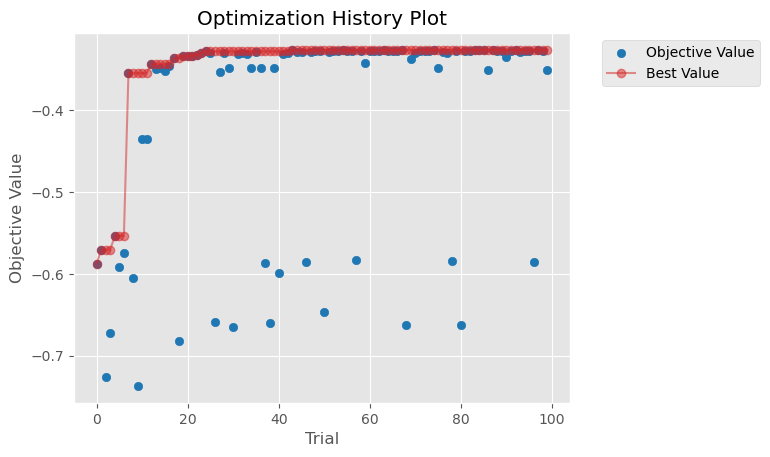

In [29]:
plot_optimization_history(study)

/tmp/ipykernel_11131/2122237422.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study);


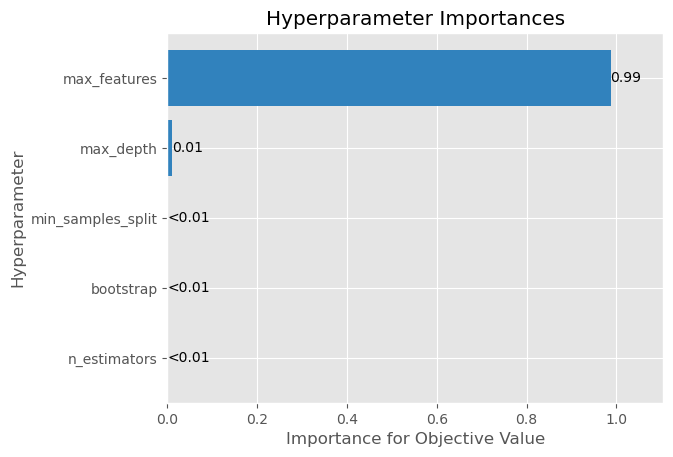

In [30]:
plot_param_importances(study);

In [33]:
best_regressor = RandomForestRegressor(random_state=8, **study.best_params)\
    .fit(X_train, y_train)

In [34]:
y_pred = best_regressor.predict(X_val)

In [35]:
mean_absolute_percentage_error(y_val, y_pred)

0.31682153721513423

Some curve examples

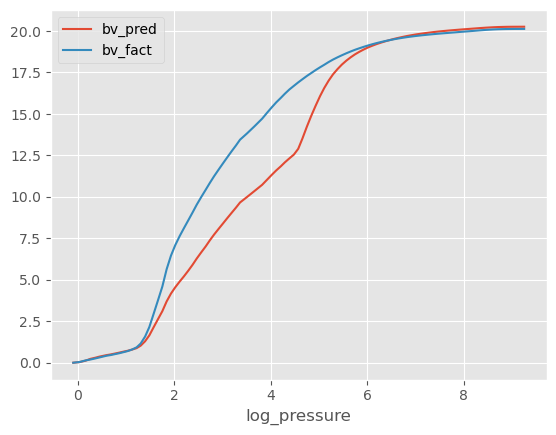

In [37]:
pd.DataFrame({'log_pressure': X_val.filter(regex='pc_').iloc[0, :].to_list(),
              'bv_pred':y_pred[0, :].tolist(),
              'bv_fact': y_val.iloc[0, :].to_list()}) \
    .plot.line(x='log_pressure', y=['bv_pred', 'bv_fact']);

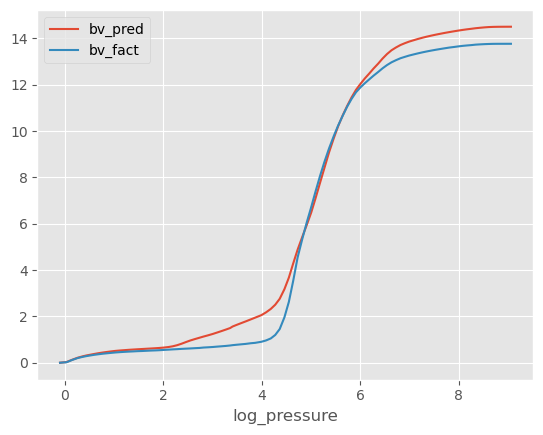

In [38]:
pd.DataFrame({'log_pressure': X_val.filter(regex='pc_').iloc[1, :].to_list(),
              'bv_pred':y_pred[1, :].tolist(),
              'bv_fact': y_val.iloc[1, :].to_list()}) \
    .plot.line(x='log_pressure', y=['bv_pred', 'bv_fact']);

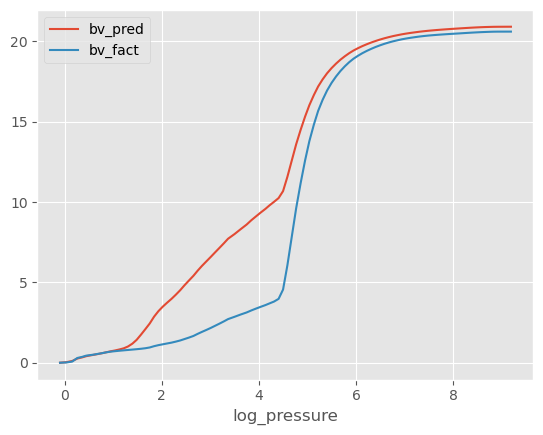

In [39]:
pd.DataFrame({'log_pressure': X_val.filter(regex='pc_').iloc[2, :].to_list(),
              'bv_pred':y_pred[2, :].tolist(),
              'bv_fact': y_val.iloc[2, :].to_list()}) \
    .plot.line(x='log_pressure', y=['bv_pred', 'bv_fact']);

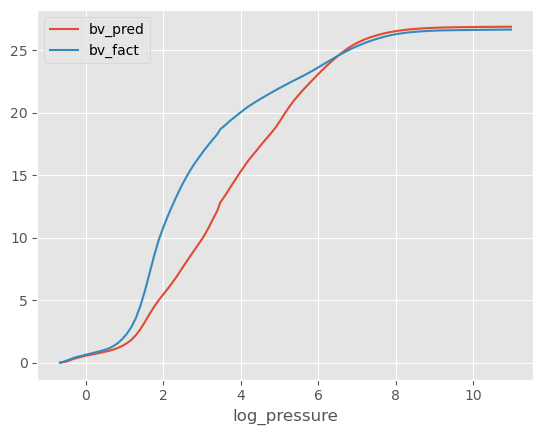

In [40]:
pd.DataFrame({'log_pressure': X_val.filter(regex='pc_').iloc[3, :].to_list(),
              'bv_pred':y_pred[3, :].tolist(),
              'bv_fact': y_val.iloc[3, :].to_list()}) \
    .plot.line(x='log_pressure', y=['bv_pred', 'bv_fact']);

Significant improvement over linear regression

## AdaBoost
AdaBoost does not support multi-output regression so I use MultiOutputRegressor.

In [14]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.multioutput import MultiOutputRegressor

In [22]:
def objective(trial):
    tree_params = {
        'max_depth': trial.suggest_int('max_tree', 10, 1000, log=True)
    }

    ada_params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000, log=True),
        'learning_rate': trial.suggest_float('lr', 0.01, 10, log=True)
    }
    tree = DecisionTreeRegressor(random_state=8, **tree_params)
    ada = AdaBoostRegressor(estimator=tree, loss='linear', random_state=8, **ada_params)
    regressor = MultiOutputRegressor(estimator=ada, n_jobs=-1)
    cv_scores = cross_val_score(regressor, 
                                X_train, y_train, 
                                scoring='neg_mean_absolute_percentage_error', 
                                cv=10)
    return cv_scores.mean()

In [23]:
study = optuna.create_study(
    pruner=optuna.pruners.HyperbandPruner(),
    direction='maximize'
)

[I 2023-03-07 18:35:31,265] A new study created in memory with name: no-name-fdfd3758-acfd-4479-b555-f923f29cd8f6


In [24]:
%%time
%%chime
study.optimize(objective, n_trials=100)

[I 2023-03-07 18:43:31,750] Trial 0 finished with value: -0.3182286006237014 and parameters: {'max_tree': 247, 'n_estimators': 94, 'lr': 0.042383775358325264}. Best is trial 0 with value: -0.3182286006237014.
[I 2023-03-07 18:44:00,381] Trial 1 finished with value: -1.1341342166201198 and parameters: {'max_tree': 112, 'n_estimators': 27, 'lr': 3.750384725158504}. Best is trial 0 with value: -0.3182286006237014.
[I 2023-03-07 18:45:19,615] Trial 2 finished with value: -0.3271534479997142 and parameters: {'max_tree': 67, 'n_estimators': 15, 'lr': 0.03785958063599961}. Best is trial 0 with value: -0.3182286006237014.
[I 2023-03-07 18:47:56,023] Trial 3 finished with value: -0.32159939875094967 and parameters: {'max_tree': 33, 'n_estimators': 30, 'lr': 0.012211095931713819}. Best is trial 0 with value: -0.3182286006237014.
[I 2023-03-07 18:49:25,177] Trial 4 finished with value: -0.3252296858003392 and parameters: {'max_tree': 70, 'n_estimators': 17, 'lr': 0.07450643663618428}. Best is tri

[I 2023-03-08 05:49:27,048] Trial 37 finished with value: -0.3152974258802068 and parameters: {'max_tree': 69, 'n_estimators': 227, 'lr': 0.01045366680251343}. Best is trial 9 with value: -0.3141605738440897.
[I 2023-03-08 06:09:08,121] Trial 38 finished with value: -0.31603452424957795 and parameters: {'max_tree': 57, 'n_estimators': 237, 'lr': 0.031221904795785238}. Best is trial 9 with value: -0.3141605738440897.
[I 2023-03-08 06:47:54,166] Trial 39 finished with value: -0.31572134728001117 and parameters: {'max_tree': 49, 'n_estimators': 465, 'lr': 0.014697316148549537}. Best is trial 9 with value: -0.3141605738440897.
[I 2023-03-08 07:12:29,855] Trial 40 finished with value: -0.3170867746577496 and parameters: {'max_tree': 92, 'n_estimators': 299, 'lr': 0.03741309483604211}. Best is trial 9 with value: -0.3141605738440897.
[I 2023-03-08 07:49:11,992] Trial 41 finished with value: -0.3158299018736809 and parameters: {'max_tree': 151, 'n_estimators': 440, 'lr': 0.01478537367096431}.

KeyboardInterrupt: 

Interrupted as it took too long and the best value was achieved at trial 9:

Trial 9 finished with value: -0.3141605738440897 and parameters: {'max_tree': 10, 'n_estimators': 272, 'lr': 0.01974826191547239}. Best is trial 9 with value: -0.3141605738440897.

In [15]:
tree = DecisionTreeRegressor(random_state=8,
                             max_depth=10)
ada = AdaBoostRegressor(estimator=tree, 
                        loss='linear', 
                        random_state=8,
                        n_estimators=272,
                        learning_rate=0.01974826191547239
                       )
best_regressor = MultiOutputRegressor(estimator=ada, n_jobs=-1)


In [16]:
best_regressor.fit(X_train, y_train)

MultiOutputRegressor(estimator=AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=10,
                                                                                 random_state=8),
                                                 learning_rate=0.01974826191547239,
                                                 n_estimators=272,
                                                 random_state=8),
                     n_jobs=-1)

In [18]:
y_pred = best_regressor.predict(X_val)

In [19]:
mean_absolute_percentage_error(y_val, y_pred)

0.2982196152206533

Some curve examples

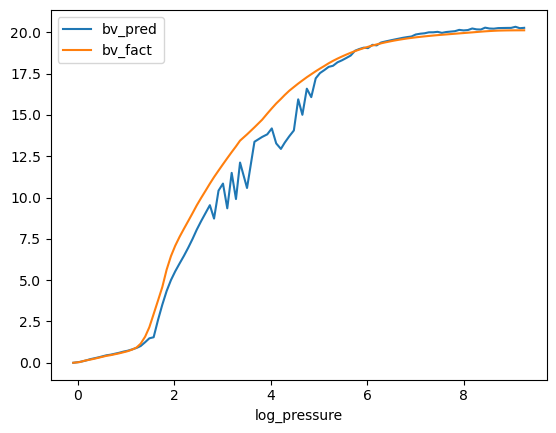

In [20]:
pd.DataFrame({'log_pressure': X_val.filter(regex='pc_').iloc[0, :].to_list(),
              'bv_pred':y_pred[0, :].tolist(),
              'bv_fact': y_val.iloc[0, :].to_list()}) \
    .plot.line(x='log_pressure', y=['bv_pred', 'bv_fact']);

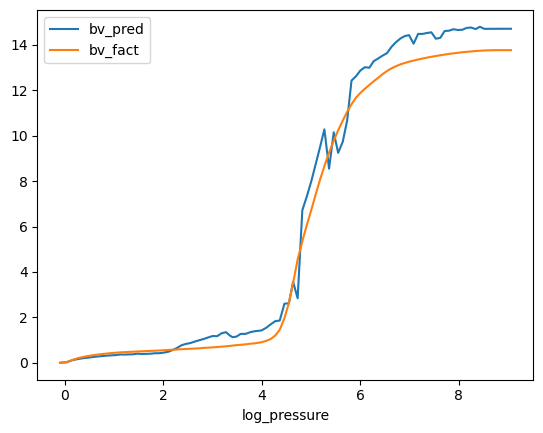

In [21]:
pd.DataFrame({'log_pressure': X_val.filter(regex='pc_').iloc[1, :].to_list(),
              'bv_pred':y_pred[1, :].tolist(),
              'bv_fact': y_val.iloc[1, :].to_list()}) \
    .plot.line(x='log_pressure', y=['bv_pred', 'bv_fact']);

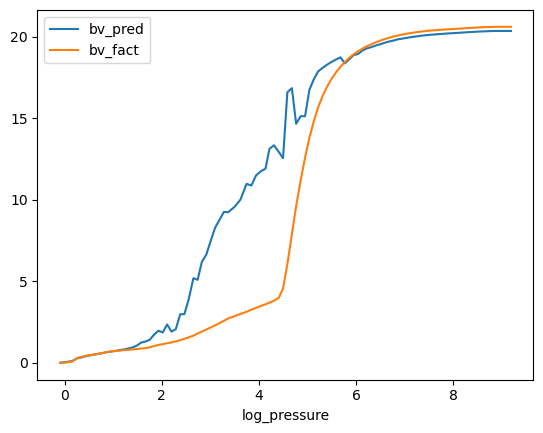

In [22]:
pd.DataFrame({'log_pressure': X_val.filter(regex='pc_').iloc[2, :].to_list(),
              'bv_pred':y_pred[2, :].tolist(),
              'bv_fact': y_val.iloc[2, :].to_list()}) \
    .plot.line(x='log_pressure', y=['bv_pred', 'bv_fact']);

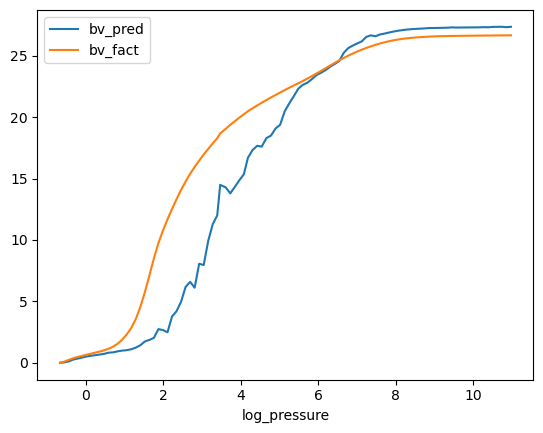

In [23]:
pd.DataFrame({'log_pressure': X_val.filter(regex='pc_').iloc[3, :].to_list(),
              'bv_pred':y_pred[3, :].tolist(),
              'bv_fact': y_val.iloc[3, :].to_list()}) \
    .plot.line(x='log_pressure', y=['bv_pred', 'bv_fact']);

# Conclusion
- This approach could be closer to real MICP experiments conducted with the purpose to determine volume-vs-pressure curves
- Whan needs to be improved: curve smoothing and constraining as injected volume should increase with pressure